# Introduction: learning simple XOR function

Learning the XOR operation is a popular elementary task, and serves here as an example to showcase the basics of simple problem encoding and the library usage.

The XOR operation has two inputs - $X \in \{0, 1\}$ and $Y \in \{0, 1\}$, and one output $XOR \in \{0, 1\}$. The whole operation can be summarized by a table

| X | Y | XOR |
|---|---|----|
| 0 | 0 |  0 |
| 1 | 0 |  1 |
| 0 | 1 |  1 |
| 1 | 1 |  0 |

<sup> \* This classic tabular form of the learning problem suggests that it is merely *propositional* (~ single table) rather than [*relational*](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-30164-8_719) (~ multible interlinked tables), which is the main aim of this library.
This will be reflected in the fact that we will not yet use *logical variables* in this example, causing the learning model to correspond to a standard feedforward network rather than a deep relational model, which is the core feature of this library.
Nevertheless, let us start simple for clarity here. </sup>

Install PyNeuraLogic from PyPI

In [1]:
! pip install neuralogic

...and import some basic functionality. The package structure should hopefully feel somewhat familiar to other deep learning frameworks (e.g., PyTorch).

In [2]:
from neuralogic.nn import get_evaluator
from neuralogic.core import Relation, Template, Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD

C:\Users\kraus\Plocha\BAK\untouched_original\PyNeuraLogic\neuralogic\core\builder\builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Defining a Dataset

First we will create a training dataset that captures the problem in scope. In the propositional case of the XOR problem,
the dataset examples correspond directly to the rows of the XOR truth table.

In [3]:
dataset = Dataset()

dataset.add_examples(
    [
        Relation.xor[0] <= Relation.xy[[0, 0]],
        Relation.xor[1] <= Relation.xy[[0, 1]],
        Relation.xor[1] <= Relation.xy[[1, 0]],
        Relation.xor[0] <= Relation.xy[[1, 1]],
    ]
)

For example, the following example can be read as: _"Given the relation xy's value equal to the vector $(0, 1)$, we expect the relation xor to be equal to a scalar $1$."_

```
Relation.xor[1] <= Relation.xy[[0, 1]]
```

While this encoding certainly feels unnecessarily verbose here, its benefits will come out clear when we move to the *relational* learning settings, where we can generally associate different output query label(s) with differently structured input examples.

## Defining a Template

Next we define a learning model, generally called "template" in PyNeuraLogic. In this simple propositional example, you can think of these interchangeably (but generally a template corresponds to a multitude of models - one for each example).

The specification of the learning template is up to the user - here we will specify a simple architecture representing a classic feedforward neural network with 1 hidden layer.

In [4]:
template = Template()
template += Relation.xor[1, 8] <= Relation.xy[8, 2]

print(template)

{1, 8} xor :- {8, 2} xy.


The rule can be read as: _"relation xor is implied by relation xy."_

<sup> \* the nullary "relation" with no arguments is commonly called a "proposition" or "fact" in logic. <sup>

Note that we further specified the *dimensionality* of parameters associated with both the relations - $W_{xor}$ = [1,8] for relation "xor" and $W_{xy}$ = [8, 2] for relation "xy"

<sup> \* These are not to be confused with arguments of the relations, e.g. logical variables, written in parentheses, which are not present in propositional problems. Also note that while defining templates, the numbers associated with each relation are interpreted as learnable weights (as opposed to actual values which we defined in the dataset examples). <sup>

These matrix parameters will then translate into our (fully-connected) layers in the neural model, and will be initialized randomly (the default uniform distribution can be changed via Settings).

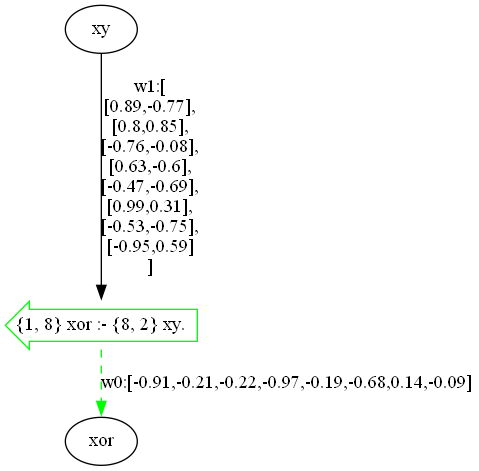

In [5]:
template.draw()

<!--- We also declared dimensionality of the weights for each part - $W_{xor}$ for relation "xor" and $W_{xy}$ for relation "xy".
-->

Let us take a closer look at what the template's rule represents here.
Once translated into a neural model, the xor rule corresponds to the following equation, where the output of $f(xy)$ is the output of the "xor" relation and $xy$ is the value of the "xy" relation.
Functions $\phi_{rule}$ and $\phi_{xor}$ are transformation functions of our rule and the relation "xor", respectively.

$$W_{xor} \in \mathbb{R}^{1, 8}, W_{xy} \in \mathbb{R}^{8, 2}, xy \in \{0,1\}^2$$

$$f(xy) = \phi_{xor}(W_{xor} \cdot \phi_{rule}(W_{xy} \cdot xy)) $$

By default Settings, both $\phi_{rule}$ and $\phi_{xor}$ are set to the $\tanh$ function.
Hence, this matrix-weighted rule represents a classic 2-layer fully-connected neural network, with a hidden layer of size 8 and a single output.

## Training

The training then does not differ much from classic deep learning frameworks (e.g. PyTorch).
We can do the training manually by writing a training loop, or using a predefined training loop implemented inside "evaluators", which are suitable for quick prototyping. Such evaluators can be conveniently customized via Settings to specify the optimizer, learning rate, error function, etc. In our example, we choose the stochastic gradient descent optimizer for training.

In [6]:
printouts = 10

settings = Settings(optimizer=SGD(), epochs=100)
evaluator = get_evaluator(template, settings)
built_dataset = evaluator.build_dataset(dataset)

for epoch, (total_loss, seen_instances) in enumerate(evaluator.train(built_dataset)):
    if epoch % printouts == 0:
        print(f"Epoch {epoch}, average loss {total_loss / seen_instances}")

Epoch 0, average loss 0.7243637669695739
Epoch 10, average loss 0.26763175590022714
Epoch 20, average loss 0.248385564712709
Epoch 30, average loss 0.23478799641307208
Epoch 40, average loss 0.21472130161044944
Epoch 50, average loss 0.1825978096134263
Epoch 60, average loss 0.13779837175692977
Epoch 70, average loss 0.09387515010336962
Epoch 80, average loss 0.06225353351108327
Epoch 90, average loss 0.0426514119522504


In the background, before the training starts, our template is firstly "grounded" against our dataset. This process then yields one computational graph per each query (example) from the dataset - i.e. 4 graphs in this case.
In this propositional problem setting, this will produce, for each query, a computational graph with the exact same structure, only with different input and target values.

<sup> while this level of dynamicity is completely unnecessary in simple propositional problems like the XOR here, it will pay off once we move to the more complex *relational* learning problems. <sup>

## Testing
Evaluators then also encapsulate testing with a user-friendly interface that is analogous to training.

In [7]:
labels = [0, 1, 1, 0]

for label, predicted in zip(labels, evaluator.test(built_dataset)):
    print(f"Label: {label}, predicted: {predicted}")

Label: 0, predicted: 0
Label: 1, predicted: 0.7608495524835678
Label: 1, predicted: 0.7703600099346454
Label: 0, predicted: 0.0460794184026012
